In [28]:
from pynq import Overlay
from math import log


In [29]:
ol = Overlay('fft.bit')

In [3]:
ol?


In [30]:
data_dma = ol.fft_block.data_dma
config_dma = ol.fft_block.config_dma

In [31]:
data_send = data_dma.sendchannel
data_recv = data_dma.recvchannel
conf_send = config_dma.sendchannel


In [32]:
def convert_to_data(fft_direction, size):
    fft_direction.zfill(8)

    byte2 = '0'*8
    x = int(log(size, 2))
    fft_size = bin(x)[2:]

    fft_size.zfill(8)
    t_data = fft_direction + byte2 + fft_size

    return int(t_data, 2)

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [34]:
SAMPLES = 8192

In [35]:
time_interval = 1
def create_data(SAMPLES, time_interval):
    A1 = random.uniform(100, 1000)
    A2 = random.uniform(100, 1000)
    A3 = random.uniform(100, 1000)
    f1 = random.uniform(100, 150)
    f2 = random.uniform(200, 300)
    f3 = random.uniform(500, 600)

    w1 = 2 * np.pi  * f1
    w2 = 2 * np.pi  * f2
    w3 = 2 * np.pi  * f3

    t = np.linspace(0, time_interval, SAMPLES)
    data = A1 * np.sin(w1*t, dtype = np.csingle) + A2 * np.sin(w2*t, dtype = np.csingle) + A3 * np.sin(w3*t, dtype = np.csingle)
    return data, t

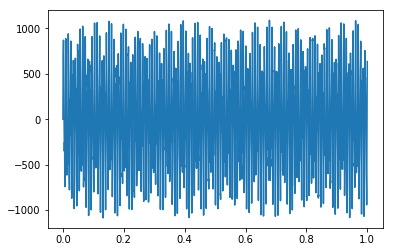

In [36]:
data, t = create_data(SAMPLES, time_interval)
plt.plot(t, np.real(data))

In [37]:
%%time
output = np.fft.fft(data)


CPU times: user 9.76 ms, sys: 910 µs, total: 10.7 ms
Wall time: 7.94 ms


In [38]:
freq = np.fft.fftfreq(SAMPLES * time_interval, 1/SAMPLES)

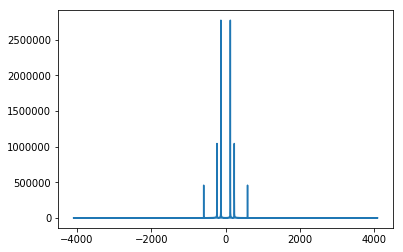

In [39]:
plt.plot(freq, np.abs(output))

In [40]:
from pynq import allocate

In [41]:
input_buffer = allocate(SAMPLES, np.csingle)
output_buffer = allocate(SAMPLES, np.csingle)

np.copyto(input_buffer, data)

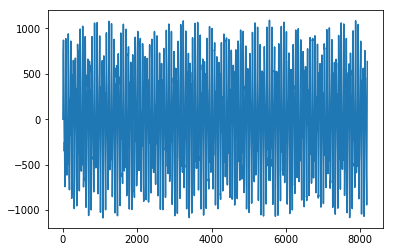

In [42]:
plt.plot(np.real(input_buffer))


In [43]:
%%time 
data_send.transfer(input_buffer)
data_recv.transfer(output_buffer)
data_send.wait()
data_recv.wait()

CPU times: user 621 µs, sys: 66 µs, total: 687 µs
Wall time: 731 µs


In [44]:
output_buffer

PynqBuffer([ 3220.81250  +0.j     ,  3220.59375 -45.90625j,
             3220.40625 -92.625j  , ...,  3221.96875+138.75j   ,
             3220.40625 +92.5j    ,  3220.62500 +45.78125j], dtype=complex64)

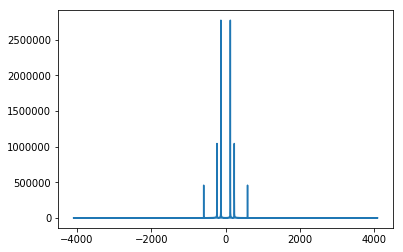

In [45]:
plt.plot(freq, np.abs(output_buffer))

In [46]:
SAMPLES = 1024
data, t = create_data(SAMPLES, time_interval)


In [47]:
conf_buffer = allocate(1, np.uint32)
conf_buffer[0] = convert_to_data('1', SAMPLES)

In [48]:
conf_send.transfer(conf_buffer)
conf_send.wait()

In [49]:
input_buffer1 = allocate(SAMPLES, np.csingle)
output_buffer1 = allocate(SAMPLES, np.csingle)
np.copyto(input_buffer1, data)

In [50]:
%%time
data_send.transfer(input_buffer1)
data_recv.transfer(output_buffer1)
data_send.wait()
data_recv.wait()

CPU times: user 481 µs, sys: 54 µs, total: 535 µs
Wall time: 586 µs


In [51]:
data_recv.transfer(output_buffer1)

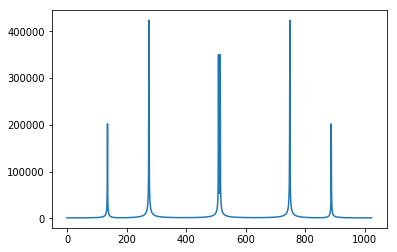

In [52]:
plt.plot(np.abs(output_buffer1))

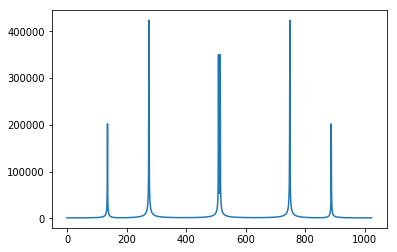

In [53]:
plt.plot(np.abs(np.fft.fft(data)))

In [54]:
%%time
output = np.fft.fft(data)

CPU times: user 1.65 ms, sys: 0 ns, total: 1.65 ms
Wall time: 1.13 ms
